In [75]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('data.csv')

In [6]:
X = df.drop("monthly_price", axis=1)
X["ber"] = X["ber"].astype("category")
y = df["monthly_price"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [7]:
param_grid = {
    "learning_rate": [0.3, 0.2, 0.1, 0.01, 0.001],
    "n_estimators": [20, 30, 50, 100, 200, 300],
    "max_depth": [2, 3, 4],
    # Add other hyperparameters to be tuned
}

regressor = xgb.XGBRegressor(enable_categorical=True, random_state=42)

grid_search = GridSearchCV(
    estimator=regressor, param_grid=param_grid, cv=5, scoring="neg_mean_squared_error"
)

grid_search.fit(X_train, y_train)
# regressor.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=True, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, ma...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             param_grid={'learning_rate': [0.3, 0.2, 0.1, 0.01, 0.001],
                         'max_depth': [2, 3, 4],
                         'n_estimators': [20, 30, 50, 100, 200, 300]},
             scoring='neg_mean_squared_error')

In [8]:
print(grid_search.best_params_)
grid_search.best_estimator_.score(X_test, y_test)
# grid_search.best_estimator_.save_model("model.json")

{'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 50}


0.6695001663241313

In [76]:
y_pred = grid_search.best_estimator_.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(np.sqrt(mse))
mae = mean_absolute_error(y_test, y_pred)
print(mae)

482.87956733382896
324.70277200686706


Text(2500, 500, 'Overpriced\n(predicted rent < actual rent)')

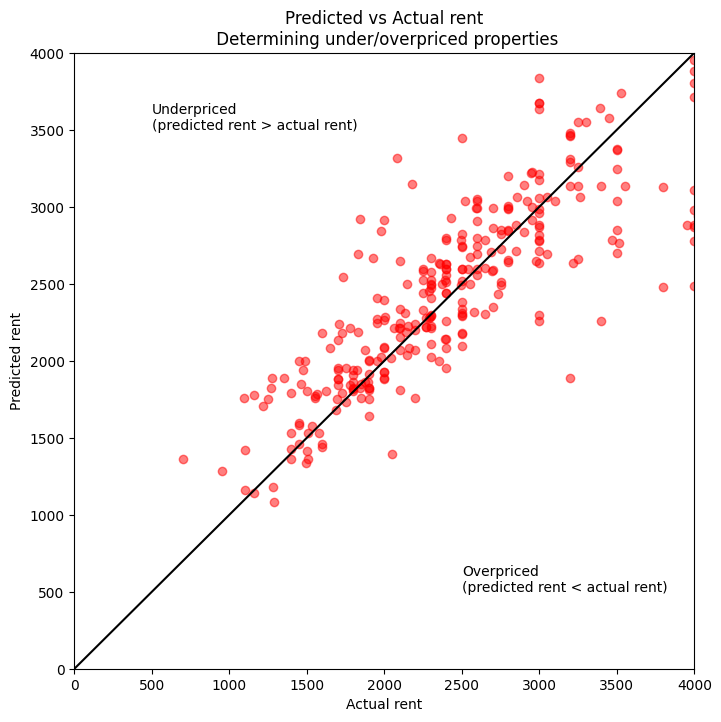

In [73]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, c="r", alpha=0.5)
plt.title("Predicted vs Actual rent\n Determining under/overpriced properties")
plt.xlim(0, 4000)
plt.ylim(0, 4000)
plt.plot([0, 4000], [0, 4000], "black")
plt.xlabel("Actual rent")
plt.ylabel("Predicted rent")
plt.annotate("Underpriced\n(predicted rent > actual rent)", (500, 3500))
plt.annotate("Overpriced\n(predicted rent < actual rent)", (2500, 500))

In [11]:
grid_search.best_estimator_.feature_importances_

array([0.3836672 , 0.32343665, 0.02710224, 0.04114705, 0.07208117,
       0.15256576], dtype=float32)

In [12]:
grid_search.best_estimator_.get_booster().feature_names

['bathrooms', 'bedrooms', 'ber', 'latitude', 'longitude', 'is_apartment']

In [13]:
grid_search.best_estimator_.get_booster().get_score(importance_type="gain")

{'bathrooms': 20754036.0,
 'bedrooms': 17495934.0,
 'ber': 1466064.75,
 'latitude': 2225802.5,
 'longitude': 3899148.25,
 'is_apartment': 8252869.5}

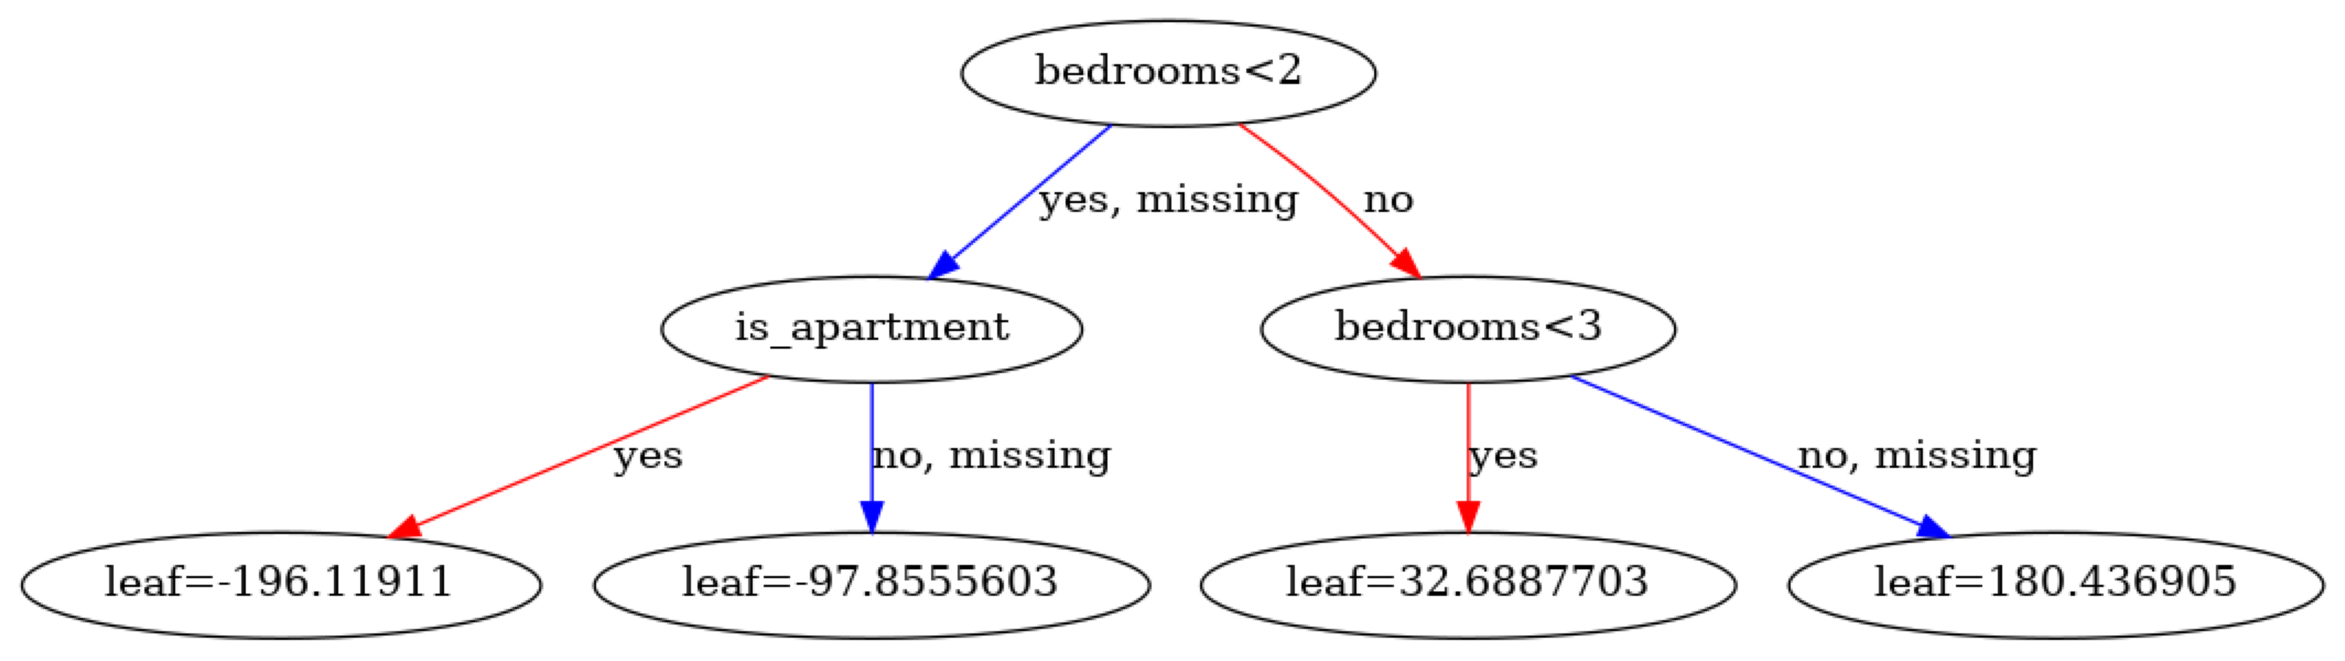

In [14]:
fig, ax = plt.subplots(figsize=(30, 30))
xgb.plot_tree(grid_search.best_estimator_, ax=ax)
plt.show()

In [62]:
check_df = pd.DataFrame(
    {
        "bathrooms": 1,
        "bedrooms": 1,
        "ber": "B",
        "latitude": 53.3490556,
        "longitude": -6.2447174,
        "is_apartment": True,
    },
    index=[0],
)
check_df["ber"] = check_df["ber"].astype("category")
grid_search.best_estimator_.predict(check_df)

array([2034.5823], dtype=float32)